# Experiments

In [1]:
import numpy as np
import math
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import os
from data.load_data import load_monk, load_MLCup
from src.MetricFunctions import get_metric_instance
from src.MLP import MLP
from src.GridSearch import GridSearch, RandomGridsearch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from src.EarlyStopping import EarlyStopping
from src.BestModelSearch import BestModelSearch

## Task 1: Regression

Preparation: Loading MLCup Dataset

In [2]:
path = os.getcwd()
file_train = '/data/ML-CUP22-TR.csv'
file_test = '/data/ML-CUP22-TS.csv'

labels_train = ['x1','x2','x3','x4','x5','x6','x7','x8','x9','y1','y2']
labels_test = ['x1','x2','x3','x4','x5','x6','x7','x8','x9']

X_train, y_train = load_MLCup(path + file_train, labels_train)
X_test = load_MLCup(path + file_test, labels_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)



(1485, 9)
(1485, 2)
(529, 9)


1.492642210726518
1.432842585519637
1.4126956726410618
25.851658457259862


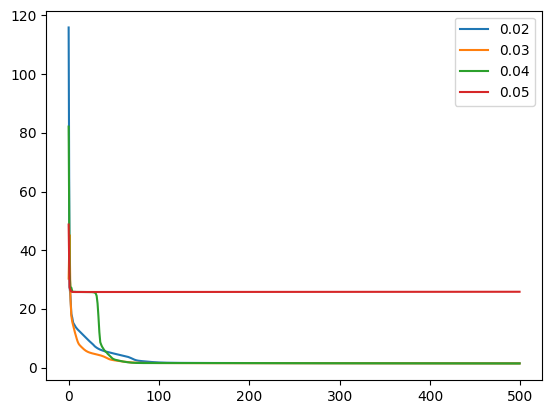

In [3]:
fig, ax = plt.subplots()
for step in [0.02,0.03,0.04,0.05]:
    mlp = MLP([60,40,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, momentum = 0.8, Nesterov = False, step = step, patience = 1000)
    ax.plot(mlp.validation_curve, label = str(step))
    print(mlp.validation_curve[499])
ax.legend()

1.714536078755941
2.5070675861208502


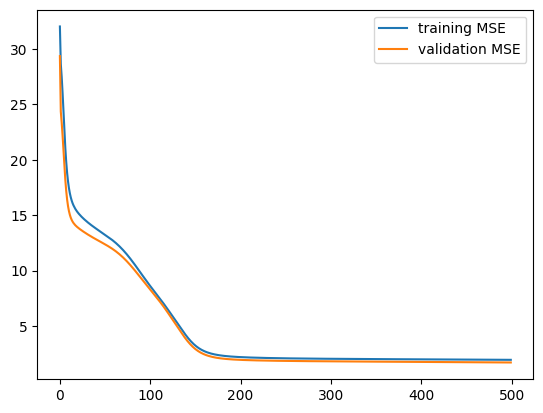

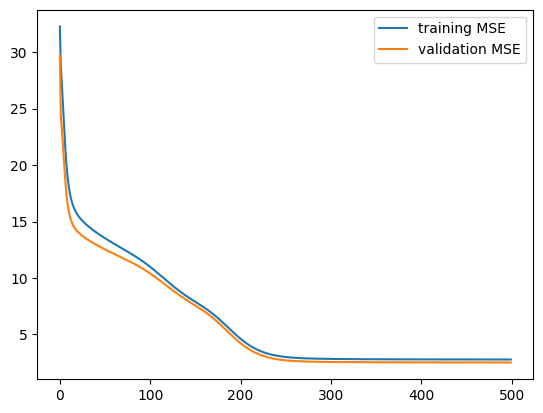

In [4]:
for alpha_l2 in [0,0.05]:
    mlp = MLP([60,20], 9, 2, task = "regression", activation_function = 'sigm')
    mlp.fit(X_train, y_train, n_epochs = 500, batch_size = 256, step = 0.02, 
            momentum = 0.8, Nesterov = True, patience = 1000, regularization = "l2", alpha_l2=alpha_l2)
    fig, ax = plt.subplots()
    ax.plot(mlp.learning_curve, label = "training MSE")
    ax.plot(mlp.validation_curve, label = "validation MSE")
    ax.legend()
    print(mlp.validation_curve[499])

## Task 2: Classification

### Preparation: Loading Monk Datasets

In [5]:
path = os.getcwd()
file_train = '/data/monks-1.train'

labels = ['class','x1','x2','x3','x4','x5','x6']

TR_sets = [[]] 
TS_sets = [[]] 
for i in range(1,4):
    TR_sets.append(load_monk(path + f'/data/monks-{i}.train', labels))
    TS_sets.append(load_monk(path + f'/data/monks-{i}.test', labels))


### Experiment 2.1 - Random Runs with Tanh

**************************************
Random Run 1

Monk Dataset 1
Accuracy on test set 1, Random Run 1: 1.0

Monk Dataset 2
Accuracy on test set 2, Random Run 1: 1.0

Monk Dataset 3
Accuracy on test set 3, Random Run 1: 0.9375

Monk Dataset 3
Accuracy on test set 3, Random Run 1: 0.9606481481481481

**************************************
Random Run 2

Monk Dataset 1
Accuracy on test set 1, Random Run 2: 0.9166666666666666

Monk Dataset 2
Accuracy on test set 2, Random Run 2: 0.9444444444444444

Monk Dataset 3
Accuracy on test set 3, Random Run 2: 0.9282407407407407

Monk Dataset 3
Accuracy on test set 3, Random Run 2: 0.9699074074074074

**************************************
Random Run 3

Monk Dataset 1
Accuracy on test set 1, Random Run 3: 1.0

Monk Dataset 2
Accuracy on test set 2, Random Run 3: 1.0

Monk Dataset 3
Accuracy on test set 3, Random Run 3: 0.9351851851851852

Monk Dataset 3
Accuracy on test set 3, Random Run 3: 0.9722222222222222

*************************************

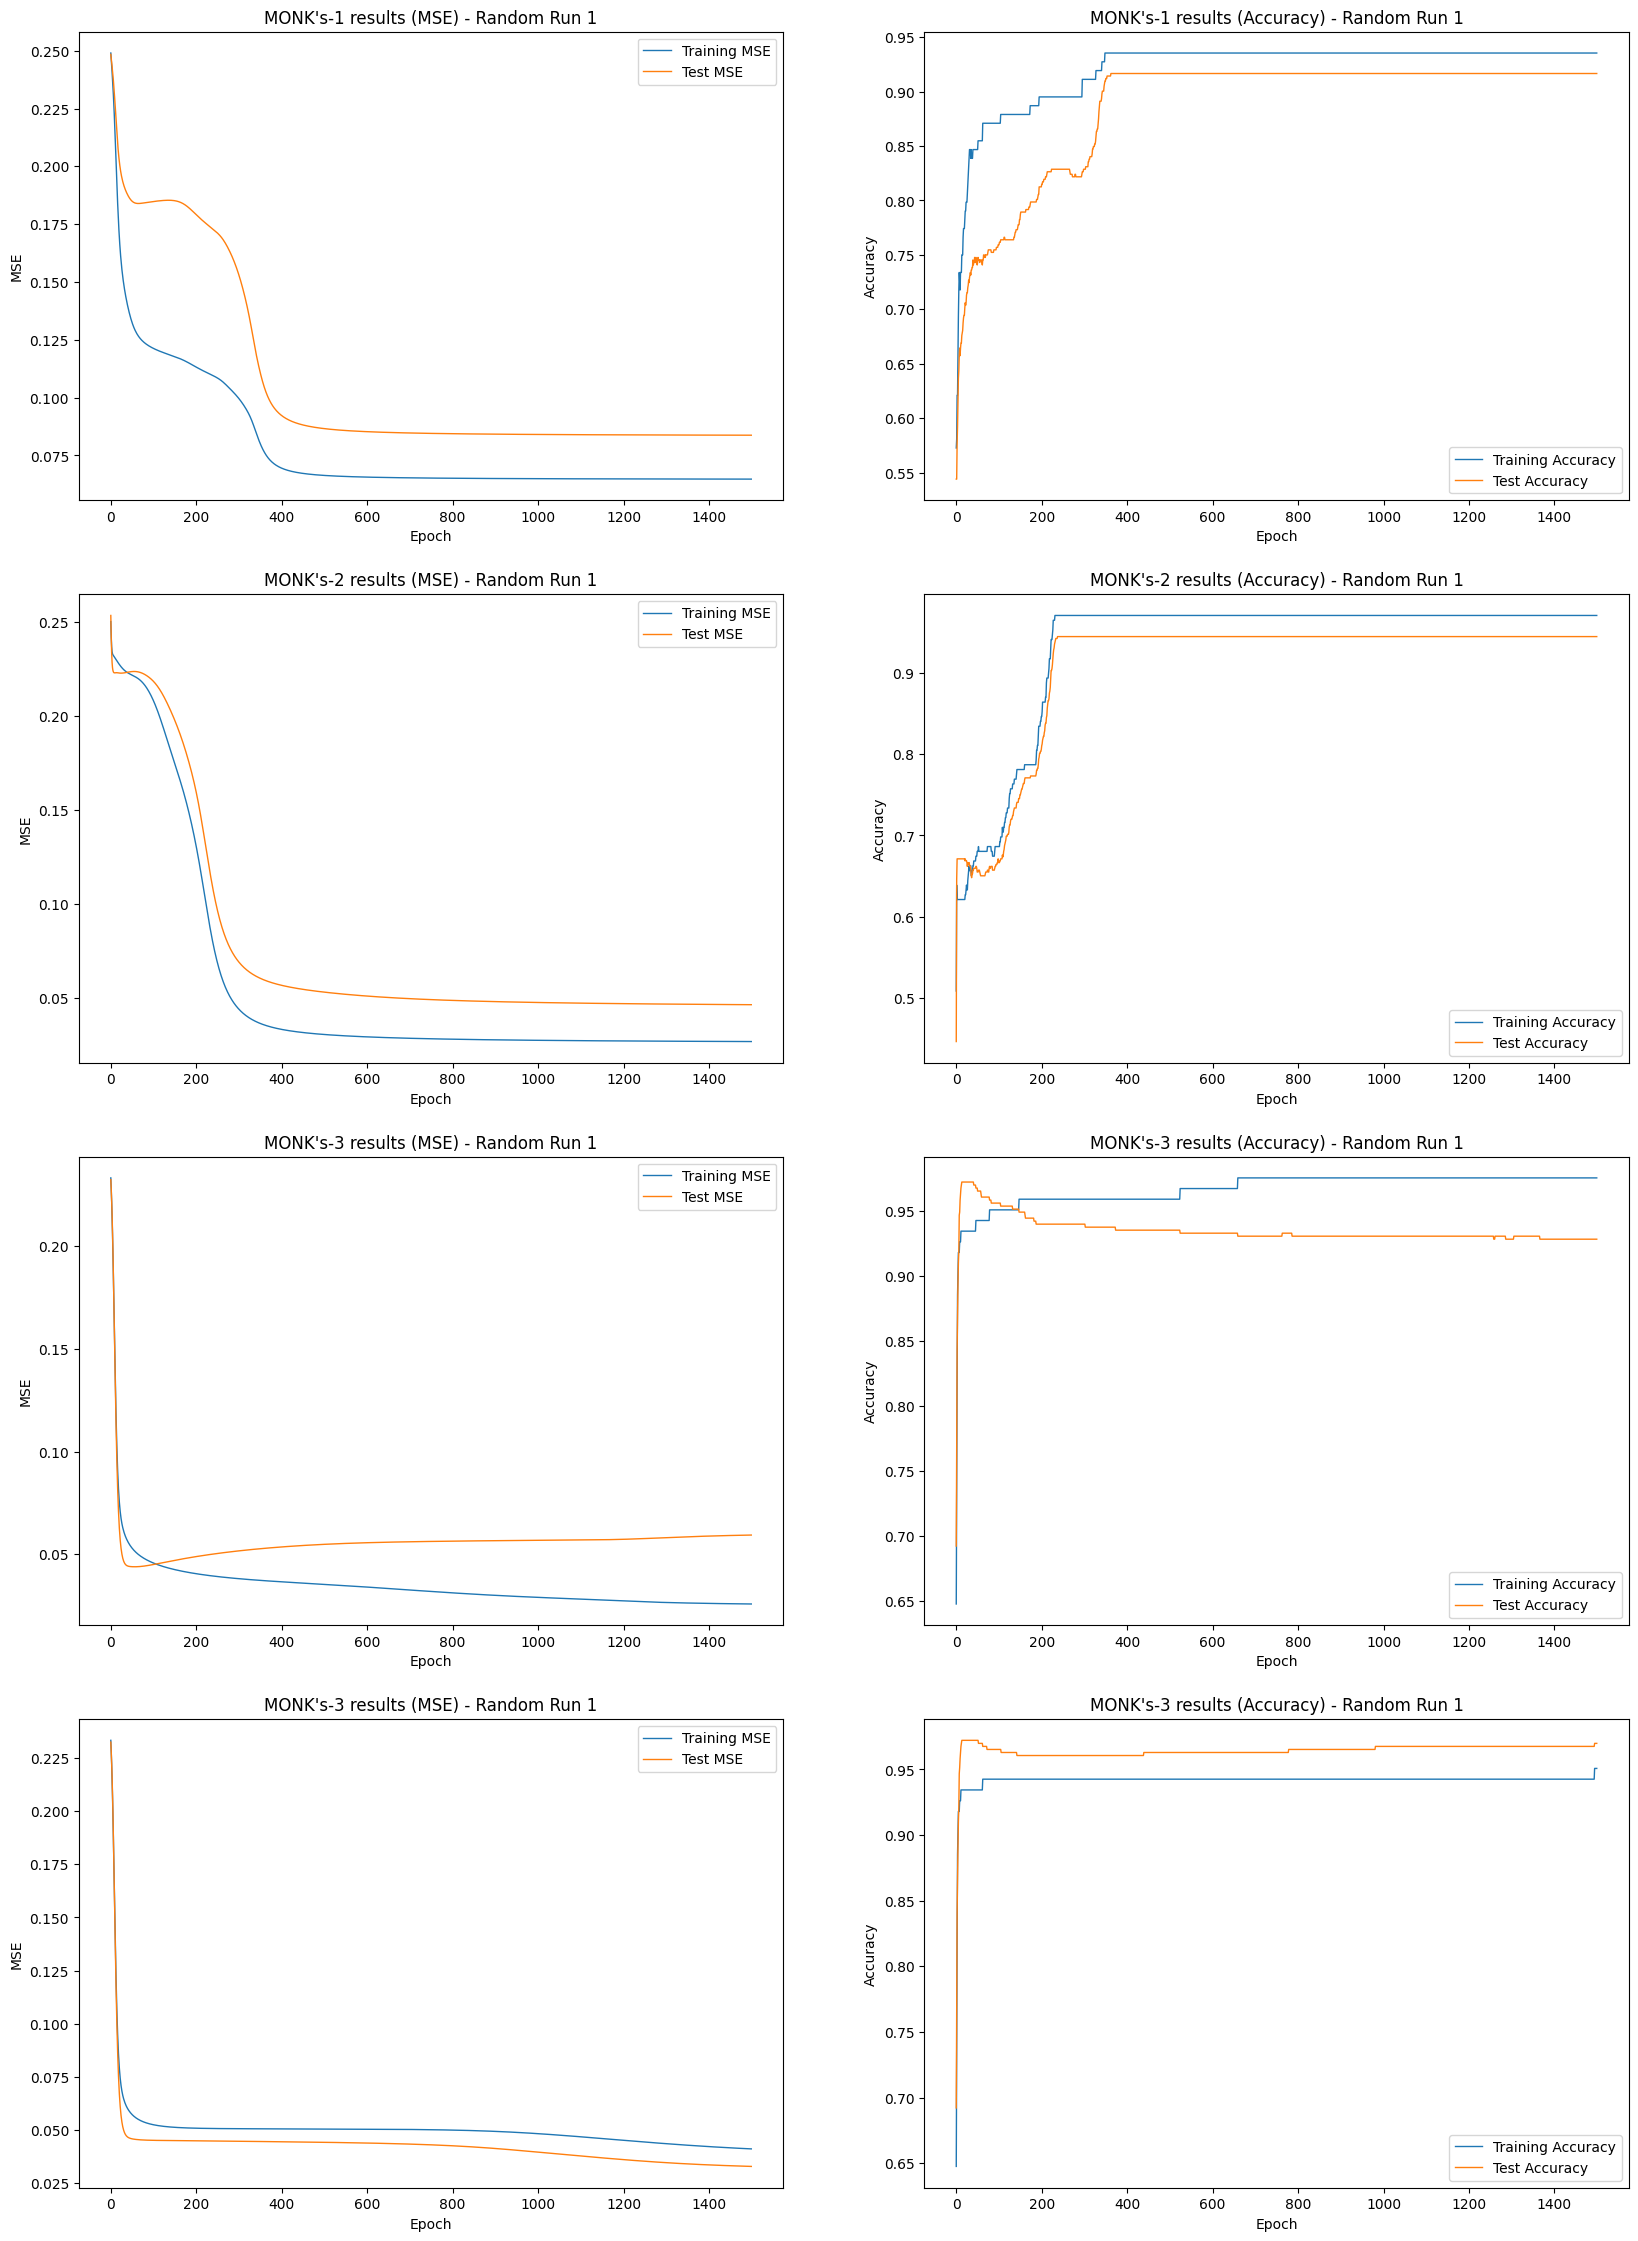

In [6]:
path = os.getcwd() + '/results/MonkResults.txt'
curves = []
params = {
    "n_epochs" : 1500, 
    "error" : "mse", 
    "verbose" : False,
    "step" : 1.5, 
    "momentum" : 0.5, 
    "weights_scale" : 0.1,
    "weights_initialization" : 'xavier',
    "early_stopping" : False,
    "eval_metric" : 'mse'
    }

# Statistics of all random runs
MSE_TR = np.zeros((10, 4))
MSE_TS = np.zeros((10, 4))
ACC_TR = np.zeros((10, 4))
ACC_TS = np.zeros((10, 4))


def name(i):
    if i in (0,1,2):
        return i + 1
    else:
        return i

# Record Statistics for 10 runs

for k in range(10):
    
    seed = np.random.randint(10000)

    print("**************************************")
    print(f"Random Run {k + 1}\n")

    for i in range(0,4):

        print(f"Monk Dataset {name(i)}")
        input_size = TR_sets[name(i)][0][0].shape[0]
        n_samples = TR_sets[name(i)][0].shape[0]
        params["batch_size"] = n_samples
        
        mlp = MLP([4], input_size = input_size, output_size = 1, task = "classification", activation_function = 'tanh', random_seed = seed)

        # Curves with MSE/Accuracy
        if i < 3:
            # All without regularization
            params["regularization"] = 'no'
            mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
        else:
            # Monk 3 with regularization
            params["regularization"] = 'l2'
            params["alpha_l2"] = 0.00075
            mlp.fit(X = TR_sets[name(i)][0], y_true = TR_sets[name(i)][1], X_test = TS_sets[name(i)][0], y_test =  TS_sets[name(i)][1], **params)
        
        if k == 1:
            curves.append([[mlp.learning_curve, mlp.learning_accuracy_curve], [mlp.validation_curve, mlp.test_accuracy_curve]])
        
        MSE_TR[k, i] = mlp.learning_curve[-1]
        MSE_TS[k, i] = mlp.validation_curve[-1]
        ACC_TR[k, i] = mlp.learning_accuracy_curve[-1]
        ACC_TS[k, i] = mlp.test_accuracy_curve[-1]

        print(f"Accuracy on test set {name(i)}, Random Run {k + 1}: {mlp.evaluate_model(TS_sets[name(i)][0], TS_sets[name(i)][1], metric = 'accuracy')}")
        print()

     
with open(path, 'w') as result_file:

    for l in range(10):
        result_file.write("**************************************\n")
        result_file.write(f"Random run {l + 1}" + '\n')

        for j in range(4):
            if j < 3:
                result_file.write(f"Results on MONK's {j + 1}: \n")
            else: 
                result_file.write(f"Results on MONK's {j} with regularization: \n")
            
            result_file.write("MSE: \tTR: " + str(MSE_TR[k, j]) + "\tTS: " + str(MSE_TS[k, j]) + '\n')
            result_file.write("ACC: \tTR: " + str(ACC_TR[k, j]) + "\tTS: " + str(ACC_TS[k, j]) + '\n')

            result_file.write('\n')
    
        result_file.write('\n')
    
    result_file.write("**************************************\n")
    result_file.write("************* STATISTICS *************\n")
    result_file.write("**************************************\n\n")

    # Mean and standard deviation over the random runs
    MSE_STAT_TR = [np.mean(MSE_TR, axis = 0), np.std(MSE_TR, axis = 0)]
    MSE_STAT_TS = [np.mean(MSE_TS, axis = 0), np.std(MSE_TS, axis = 0)]
    ACC_STAT_TR = [np.mean(ACC_TR, axis = 0), np.std(ACC_TR, axis = 0)]
    ACC_STAT_TS = [np.mean(ACC_TS, axis = 0), np.std(ACC_TS, axis = 0)]


    for m in range(4):
        if m < 3:
            result_file.write(f"Results on MONK's {m + 1} over all random runs: \n")
        else: 
            result_file.write(f"Results on MONK's {m} with regularization over all random runs: \n")
       
        result_file.write("MSE on TR: " + str(MSE_STAT_TR[0][m]) + " +/- " + str(MSE_STAT_TR[1][m]) + '\n')
        result_file.write("MSE on TS: " + str(MSE_STAT_TS[0][m]) + " +/- " + str(MSE_STAT_TS[1][m]) + '\n')
        result_file.write("ACC on TR: " + str(ACC_STAT_TR[0][m]) + " +/- " + str(ACC_STAT_TR[1][m]) + '\n')
        result_file.write("ACC on TS: " + str(ACC_STAT_TS[0][m]) + " +/- " + str(ACC_STAT_TS[1][m]) + '\n')
        result_file.write('\n')


# Plot the learning curves
figure, axis = plt.subplots(4, 2, figsize = (20, 28))

for j in range(0,4):

    # Plot MSE training and validation curves
    axis[j, 0].plot(range(0, len(curves[j][0][0]), 1), curves[j][0][0],\
        linewidth = 1, label = 'Training MSE')
    axis[j, 0].plot(range(0, len(curves[j][1][0]), 1), curves[j][1][0],\
        linewidth = 1, label = 'Test MSE')
    axis[j, 0].set_title(f"MONK's-{name(j)} results (MSE) - Random Run 1")
    axis[j, 0].set_xlabel('Epoch') 
    axis[j, 0].set_ylabel('MSE')  
    axis[j, 0].legend()


    # Plot Accuracy training and validation curves
    axis[j, 1].plot(range(0, len(curves[j][0][1]), 1), curves[j][0][1],\
        linewidth = 1, label = 'Training Accuracy')
    axis[j, 1].plot(range(0, len(curves[j][1][1]), 1), curves[j][1][1],\
        linewidth = 1, label = 'Test Accuracy')
    axis[j, 1].set_title(f"MONK's-{name(j)} results (Accuracy) - Random Run 1")
    axis[j, 1].set_xlabel('Epoch') 
    axis[j, 1].set_ylabel('Accuracy')  
    axis[j, 1].legend()

plt.show()
